# Uncertainty Estimation using TensorFlow Probability

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
tf.compat.v1.enable_eager_execution()

import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 1.15.0-dev20190730
TensorFlow Probability version: 0.8.0-dev20190801


## Build the dataset for regression

In [2]:
def load_dataset(n, w0, b0, x_low, x_high):
    def s(x):
        g = (x - x_low) / (x_high - x_low)
        return 3 * (0.25 + g**2)
    def f(x, w, b):
        return w * x * (1. + np.sin(x)) + b
    x = (x_high - x_low) * np.random.rand(n) + x_low  # N(x_low, x_high)
    x = np.sort(x)
    eps = np.random.randn(n) * s(x)
    y = f(x, w0, b0) + eps
    return x, y

X_train.shape = (400, 1)
y_train.shape = (400, 1)
X_test.shape = (100, 1)


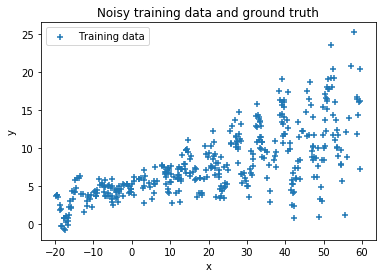

In [3]:
n_data = 500
n_train = 400
w0 = 0.125
b0 = 5.0
x_low, x_high = -20, 60

X, y = load_dataset(n_data, w0, b0, x_low, x_high)
X = np.expand_dims(X, 1)
y = np.expand_dims(y, 1)

idx_randperm = np.random.permutation(n_data)
idx_train = np.sort(idx_randperm[:n_train])
idx_test = np.sort(idx_randperm[n_train:])

X_train, y_train = X[idx_train], y[idx_train]
X_test = X[idx_test]

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)

plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Traditional point-estimate neural network

### Define the loss function of negative log-likelihood (input as prediction)

In [4]:
def neg_log_likelihood_with_dist(y_true, y_pred):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

### Define and train the model

In [5]:
batch_size = 100
n_epochs = 3000
lr = 5e-3

def build_point_estimate_model(scale=1):
    model_in = Input(shape=(1,))
    x = Dense(16)(model_in)
    x = LeakyReLU(0.1)(x)
    x = Dense(64)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(16)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(1)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t, scale=scale))(x)
    model = Model(model_in, model_out)
    return model

pe_model = build_point_estimate_model()
pe_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
pe_model.summary()
hist = pe_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0)

W0813 12:32:42.229280  8440 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0     

### Plot the training loss and predict the test data

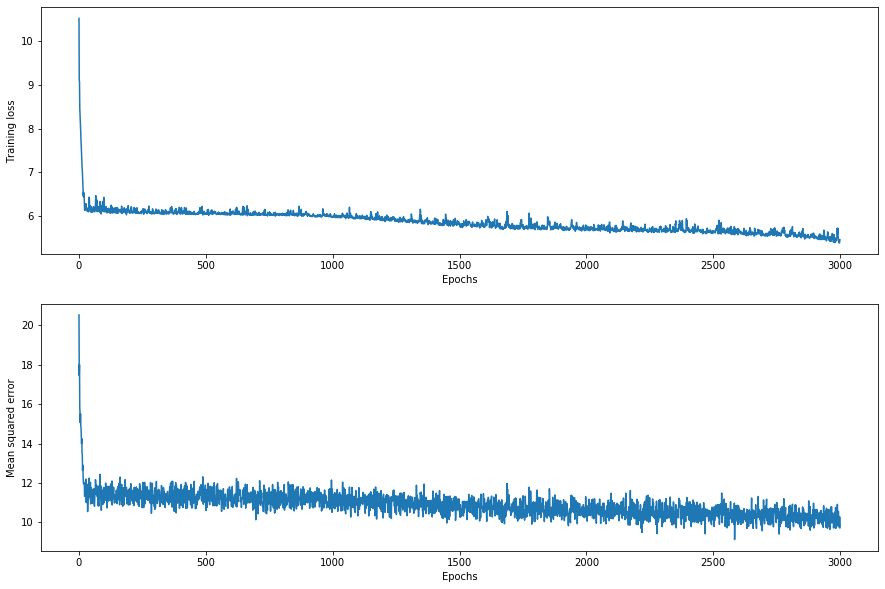

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(range(n_epochs), hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[1].plot(range(n_epochs), hist.history['mean_squared_error'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
y_test_pred_pe = pe_model(X_test)

### Plot the training and test data

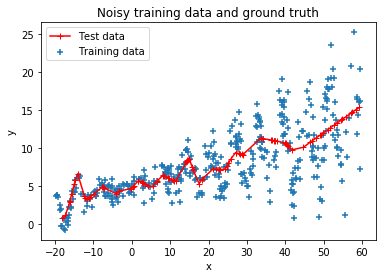

In [7]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.plot(X_test, y_test_pred_pe.mean(), 'r-', marker='+', label='Test data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Estimate aleatoric uncertainty

### Define and train the model

In [8]:
def build_aleatoric_model():
    model_in = Input(shape=(1,))
    x = Dense(16)(model_in)
    x = LeakyReLU(0.1)(x)
    x = Dense(64)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(16)(x)
    x = LeakyReLU(0.1)(x)
    model_out_loc = Dense(1)(x)
    model_out_scale = Dense(1)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[0],
                                                        scale=1e-7 + tf.math.softplus(1e-3 * t[1])))([model_out_loc,
                                                                                                      model_out_scale])
    model = Model(model_in, model_out)
    return model

al_model = build_aleatoric_model()
al_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
al_model.summary()
hist = al_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 16)           32          input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 16)           0           dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           1088        leaky_re_lu_3[0][0]              
____________________________________________________________________________________________

### Plot the training loss and predict the test data

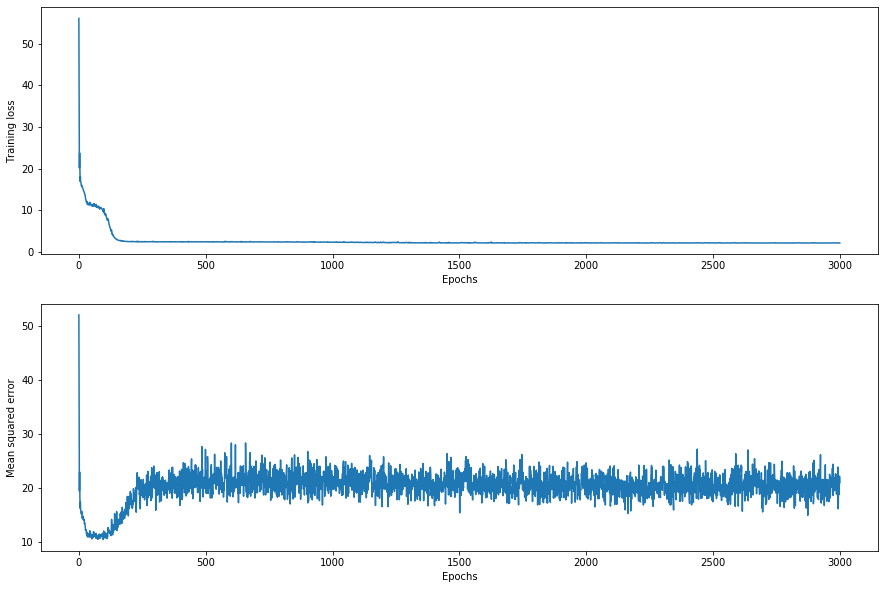

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(range(n_epochs), hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[1].plot(range(n_epochs), hist.history['mean_squared_error'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
y_test_pred_al = al_model(X_test)
y_test_pred_al_mean = y_test_pred_al.mean()
y_test_pred_al_stddev = y_test_pred_al.stddev()

### Plot the training and test data

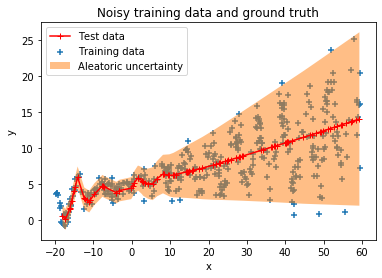

In [10]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.plot(X_test, y_test_pred_al_mean, 'r-', marker='+', label='Test data')
plt.fill_between(np.squeeze(X_test), 
                 np.squeeze(y_test_pred_al_mean + 2 * y_test_pred_al_stddev),
                 np.squeeze(y_test_pred_al_mean - 2 * y_test_pred_al_stddev),
                 alpha=0.5, label='Aleatoric uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Estimate epistemic uncertainty

In [11]:
n_epochs = 10000
lr = 5e-3
n_test = 10

### Specify the surrogate posterior over `kernel` and `bias` of `DenseVariational`

In [12]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    return Sequential([tfp.layers.VariableLayer(2 * n, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                           tfd.Normal(loc=t[..., :n], scale=1e-7 + tf.nn.softplus(c + t[..., n:])),
                           reinterpreted_batch_ndims=1))
    ])

### Specify the prior over `kernel` and `bias` of `DenseVariational`

In [13]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return Sequential([tfp.layers.VariableLayer(n, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                           tfd.Normal(loc=t, scale=1.0), reinterpreted_batch_ndims=1)),
    ])

### Define and train the model

In [14]:
def build_epistemic_model(train_size, scale=1):
    model_in = Input(shape=(1,))
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(64, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t, scale=scale))(x)
    model = Model(model_in, model_out)
    return model

ep_model = build_epistemic_model(n_train, scale=10)
ep_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
ep_model.summary()
hist = ep_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_variational (DenseVari (None, 16)                96        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_variational_1 (DenseVa (None, 64)                3264      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_variational_2 (DenseVa (None, 16)                3120      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16)                0   

### Show all layer names, weight names and shapes

In [15]:
print({l.name: {w.name: w.numpy().shape for w in l.weights} for l in ep_model.layers})

{'input_3': {}, 'dense_variational': {'dense_variational/constant:0': (32,)}, 'leaky_re_lu_6': {}, 'dense_variational_1': {'dense_variational_1/constant:0': (1088,)}, 'leaky_re_lu_7': {}, 'dense_variational_2': {'dense_variational_2/constant:0': (1040,)}, 'leaky_re_lu_8': {}, 'dense_variational_3': {'dense_variational_3/constant:0': (17,)}, 'distribution_lambda_2': {}}


### Plot the training loss and predict the test data

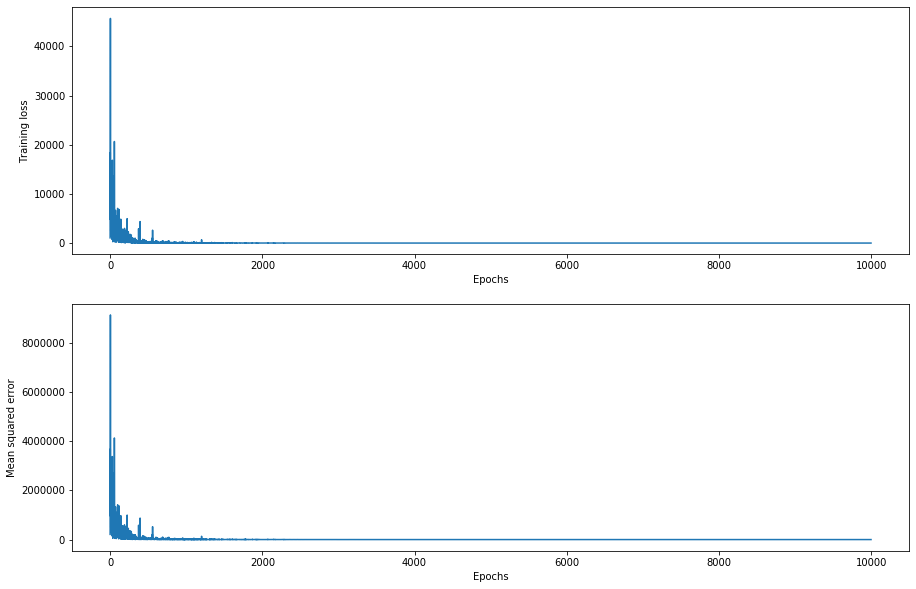

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(range(n_epochs), hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[1].plot(range(n_epochs), hist.history['mean_squared_error'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
y_test_pred_ep_list = [ep_model(X_test) for _ in range(n_test)]

### Plot the training and test data

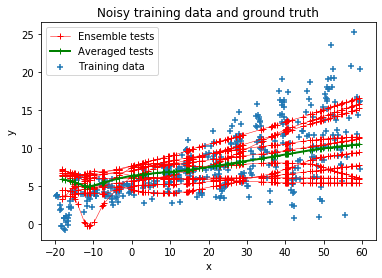

In [17]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
avg_mean = np.zeros_like(X_test)
for i, y in enumerate(y_test_pred_ep_list):
    y_mean = y.mean()
    plt.plot(X_test, y_mean, 'r-', marker='+', label='Ensemble tests' if i == 0 else None, linewidth=0.5)
    avg_mean += y_mean
plt.plot(X_test, avg_mean/n_test, 'g-', marker='+', label='Averaged tests', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Estimate aleatoric + epistemic uncertainty

### Define and train the model

In [18]:
def build_aleatoric_epistemic_model(train_size):
    model_in = Input(shape=(1,))
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    model_out_loc = DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out_scale = DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[0],
                                                        scale=1e-7 + tf.math.softplus(1e-3 * t[1])))([model_out_loc,
                                                                                                      model_out_scale])
    model = Model(model_in, model_out)
    return model

ae_model = build_aleatoric_epistemic_model(n_train)
ae_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
ae_model.summary()
hist = ae_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_variational_4 (DenseVaria (None, 16)           96          input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 16)           0           dense_variational_4[0][0]        
__________________________________________________________________________________________________
dense_variational_5 (DenseVaria (None, 16)           816         leaky_re_lu_9[0][0]              
____________________________________________________________________________________________

### Show all layer names, weight names and shapes

In [19]:
print({l.name: {w.name: w.numpy().shape for w in l.weights} for l in ae_model.layers})

{'input_4': {}, 'dense_variational_4': {'dense_variational_4/constant:0': (32,)}, 'leaky_re_lu_9': {}, 'dense_variational_5': {'dense_variational_5/constant:0': (272,)}, 'leaky_re_lu_10': {}, 'dense_variational_6': {'dense_variational_6/constant:0': (17,)}, 'dense_variational_7': {'dense_variational_7/constant:0': (17,)}, 'distribution_lambda_3': {}}


### Plot the training loss and predict the test data

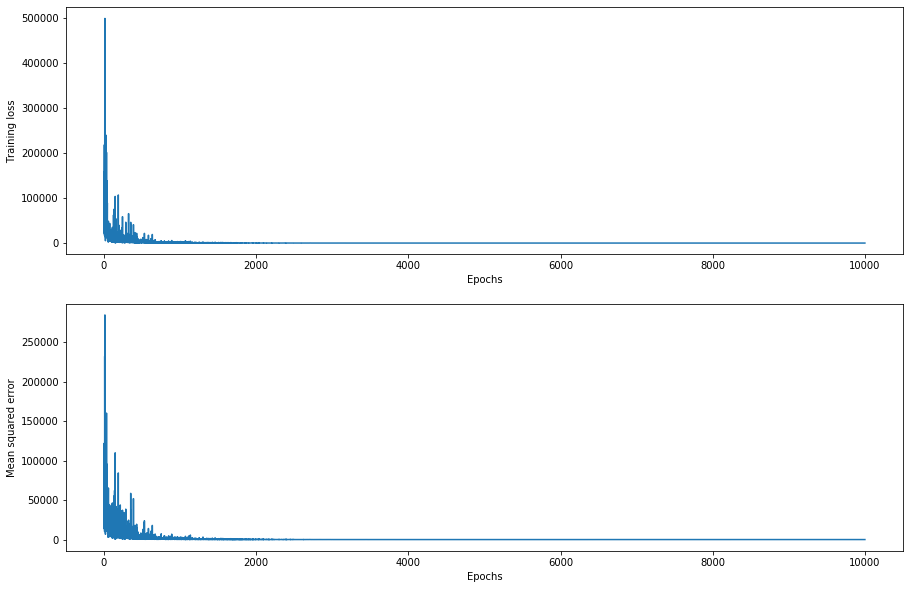

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(range(n_epochs), hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[1].plot(range(n_epochs), hist.history['mean_squared_error'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
y_test_pred_ae_list = [ae_model(X_test) for _ in range(n_test)]

### Plot the training and test data

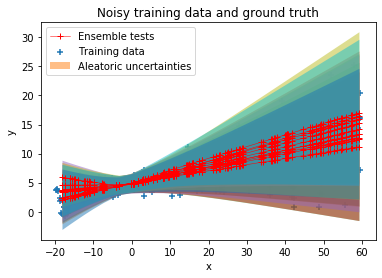

In [21]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
avg_mean = np.zeros_like(X_test)
for i, y in enumerate(y_test_pred_ae_list):
    y_mean = y.mean()
    y_stddev = y.stddev()
    plt.plot(X_test, y_mean, 'r-', marker='+', label='Ensemble tests' if i == 0 else None, linewidth=0.5)
    plt.fill_between(np.squeeze(X_test), 
                     np.squeeze(y_mean + 2 * y_stddev),
                     np.squeeze(y_mean - 2 * y_stddev),
                     alpha=0.5, label='Aleatoric uncertainties' if i == 0 else None)
    avg_mean += y_mean
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Uncertainties in CNNs

### Define the loss function of negative log-likelihood (input as logits)

In [22]:
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

### Load MNIST dataset

Loading MNIST dataset
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


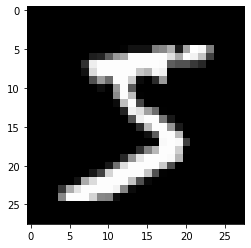

In [23]:
n_class = 10

batch_size = 128
n_epochs = 20
lr = 1e-3

print('Loading MNIST dataset')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[0, :, :, 0], cmap='gist_gray')

### Define the kernel divergence function that comes with a weight

In [24]:
def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

In [25]:
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

### Build and train the Bayesian CNN model

In [26]:
def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(10, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    
bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], n_train)
bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'])
bcnn_model.summary()
hist = bcnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_split=0.1)

W0813 12:38:56.628603  8440 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_probability\python\layers\util.py:103: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (None, 14, 14, 32)        609       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 7, 7, 64)          36929     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0   

### Quantify the uncertainty in predictions

In [27]:
n_mc_run = 50
med_prob_thres = 0.2

y_pred_logits_list = [bcnn_model.predict(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9996
Unrecognizable samples: [ 247 2927 6572 9634]
Test accuracy on MNIST (recognizable samples): 0.9888955582232893
Test accuracy on MNIST (unrecognizable samples): 0.25


### Define the function that plots the histogram of predicted probabilities across all possible classes

In [28]:
def plot_pred_hist(y_pred, n_class, n_mc_run, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-30, 0, 31)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=(25, 10))
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                       np.median(y_pred[idx]),
                                                                       str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

### A recognizable example

True label of the test sample 0: 7


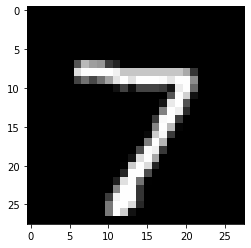

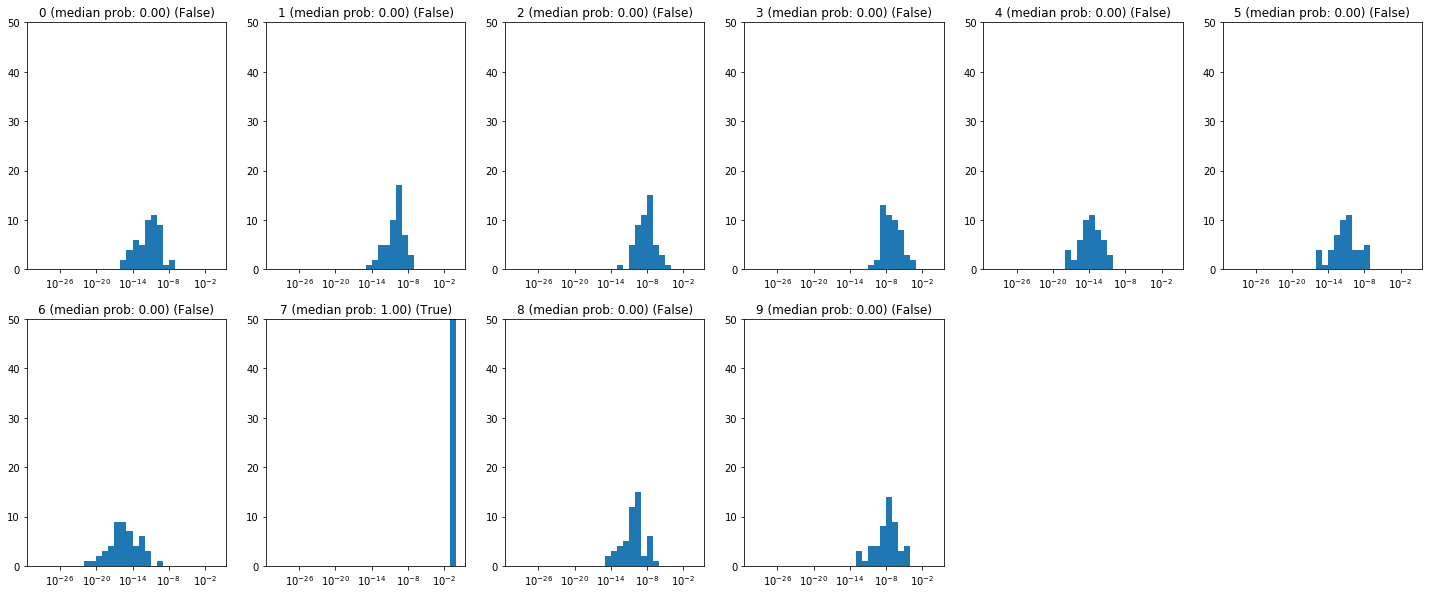

Predicted label of the test sample 0: 7


In [29]:
idx = 0
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

### An unrecognizable example

True label of the test sample 247: 4


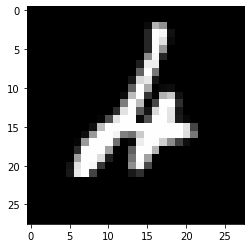

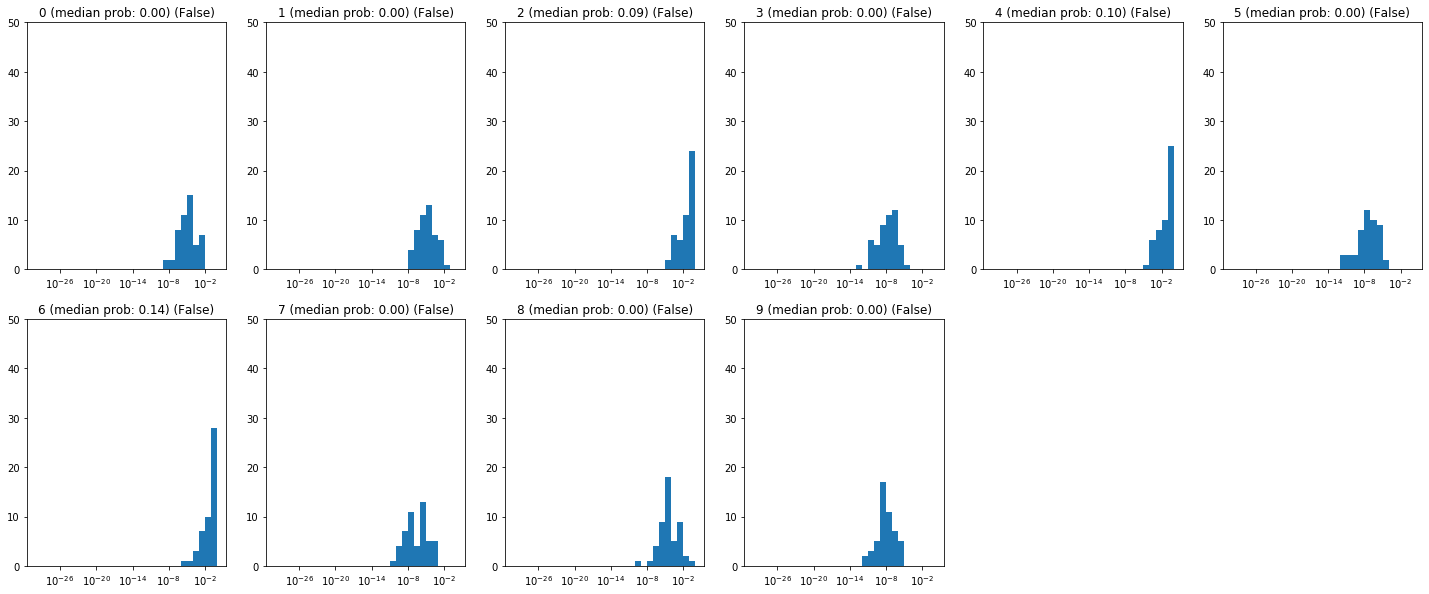

I don't know!


In [30]:
idx = np.where(idx_invalid)[0][0]
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

### Load Fashion-MNIST dataset

In [31]:
print('Loading Fashion-MNIST dataset')
_, (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_test = np.expand_dims(X_test, -1)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

Loading Fashion-MNIST dataset
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


### Quantify the uncertainty in predictions

In [32]:
y_pred_logits_list = [bcnn_model.predict(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 1370
Unrecognizable samples: [   1    2    3 ... 9997 9998 9999]
Test accuracy on MNIST (recognizable samples): 0.020437956204379562
Test accuracy on MNIST (unrecognizable samples): 0.11158748551564311


### An unrecognizable example

True label of the test sample 1: 2


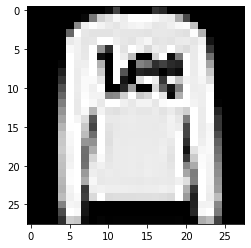

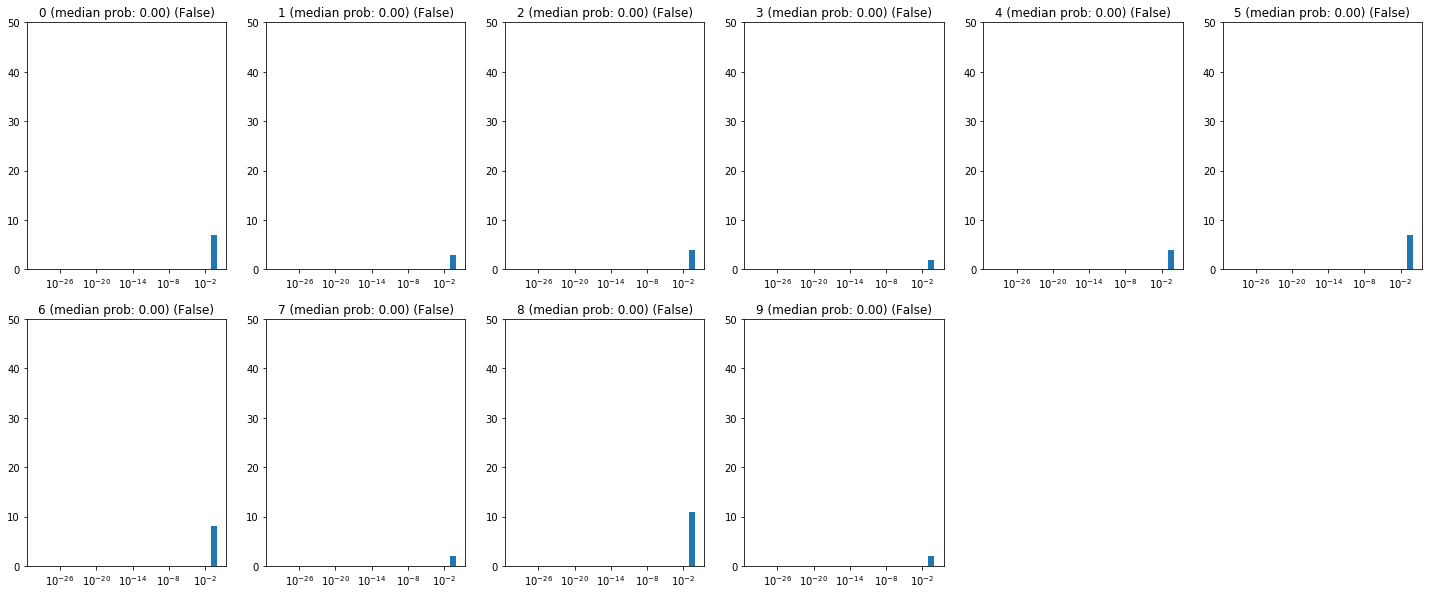

I don't know!


In [33]:
idx = np.where(idx_invalid)[0][0]
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

## Generate an HTML version of this notebook

In [34]:
!!python -m nbconvert *.ipynb

['[NbConvertApp] Converting notebook tfp_bnn.ipynb to html',
 '[NbConvertApp] Writing 831114 bytes to tfp_bnn.html']